In [1]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import math
import gtsam
import json

import matplotlib
import matplotlib.pyplot as plt
import gtsam.utils.plot as gtsam_plot

from vehicle_lib.numpy_helper import np_normalize_angle_mpi_to_pi, rotate_vector_2d
from landmark_tracking_helper import simulate_odometry_and_GPS, sense_landmark_on_given_trace, plot_overview 

# Basic example to Simultaneous Localisation and Mappign (SLAM) for a single vehicle

## Load a trace

This trace was produced by a vehicle model as serves as ground truth.

In [2]:
with open('data/path_to_goal_2.json') as json_file:
    raw_trace = json.load(json_file)

## Define landmark positions

In [3]:
# define landmark ground truth
landmarks_ground_truth = pd.DataFrame()

landmarks_ground_truth["landmark_id"] = np.array( [1,    2,      3], dtype=np.int64 )
landmarks_ground_truth["x"]           = np.array( [10.0, 9.0, 20.0], dtype=np.float64 )
landmarks_ground_truth["y"]           = np.array( [0.0,  5.0, 10.0], dtype=np.float64 )
landmarks_ground_truth

,landmark_id,x,y
0,1,10.0,0.0
1,2,9.0,5.0
2,3,20.0,10.0


# Generate measurement data via simulation

## Simulate the sensors for localisation of vehicle

Herein, the vehicle odometry and GPS are modelled and simulated yielding a trace of bearing measurements and GPS positions/headings.


In [4]:
trace = {}
pdf_odometry_measurements, pdf_gps_measurements = simulate_odometry_and_GPS(raw_trace, trace, number_of_samples=100)

In [5]:
pdf_odometry_measurements

,d_delta,psi_delta
0,0.209977,0.054803
1,0.209974,0.058460
2,0.209971,0.062101
3,0.209967,0.065715
4,0.209963,0.057657
...,...,...
94,0.209997,0.022870
95,0.209989,0.037808
96,0.209987,0.041411
97,0.209985,0.045044


In [6]:
pdf_gps_measurements

,x,y,psi,index_in_trace
0,24.853632,0.238632,2.166651,1
1,19.644942,2.758442,3.061277,25
2,13.873909,1.427225,3.395294,50
3,7.460165,4.139245,2.282433,74
4,5.000000,10.000001,1.981954,99


## Simulate the bearing/distance measurement of landmarks

In [7]:
# Simulate landmark observations
landmarks_observations_by_id = {}
pdf_landmarks_bearing = pd.DataFrame()
    
for i, row in enumerate(landmarks_ground_truth.itertuples()):
    
    landmark_id    = row.landmark_id
    landmark_xy_gt = [ row.x, row.y ]

    n_observations_per_landmark, I_low_distance_and_visible, bearing_angle, bearing_distance = sense_landmark_on_given_trace( 
        trace['x_y_psi'], 
        landmark_xy_gt 
    )

    pdf_landmark_bearing = pd.DataFrame()
    pdf_landmark_bearing["landmark_id"]                                = landmark_id*np.ones(n_observations_per_landmark, dtype=np.int64)
    pdf_landmark_bearing["index_in_trace_where_landmark_was_seen"]     = I_low_distance_and_visible
    pdf_landmark_bearing["bearing_angle"]                              = bearing_angle
    pdf_landmark_bearing["bearing_distance"]                           = bearing_distance
    
    landmarks_observations_by_id[ landmark_id ] = {
        'I_low_distance_and_visible' : I_low_distance_and_visible,  # the indices of the samples in the trace at which the landmark was seen.
        'landmark_xy_gt' : landmark_xy_gt,
    }
    
    # concatenate the data for each landmark
    if i==0:
        pdf_landmarks_bearing = pdf_landmark_bearing
    else:
        pdf_landmarks_bearing = pd.concat( ( pdf_landmarks_bearing, pdf_landmark_bearing ), axis=0  )

    
trace['bearing_noise'] =       [ 0.01, 0.4 ]

In [8]:
pdf_landmarks_bearing

,landmark_id,index_in_trace_where_landmark_was_seen,bearing_angle,bearing_distance
0,1,34,0.171674,7.896670
1,1,35,0.149028,7.656185
2,1,36,0.125928,7.416039
3,1,37,0.102208,7.175155
4,1,38,0.077799,6.933649
...,...,...,...,...
2,3,18,-1.098931,7.711854
3,3,19,-1.161027,7.596353
4,3,20,-1.223546,7.497585
5,3,21,-1.285351,7.416694


## Plot the visibility of the landmarks

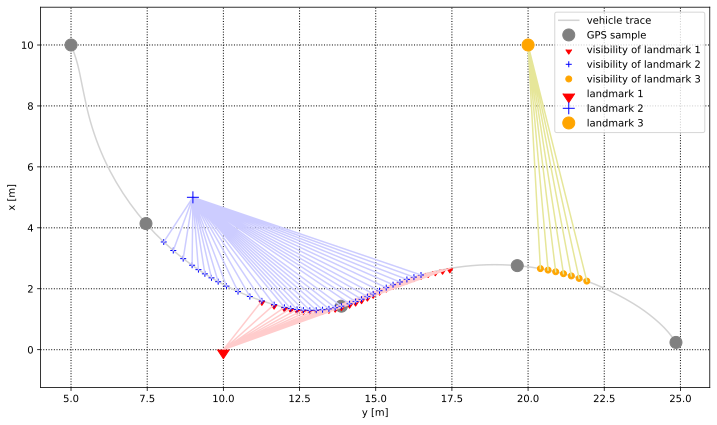

In [9]:
landmarks_to_show = [
    [1, "red",    (1.0, 0.8, 0.8), matplotlib.markers.CARETDOWNBASE ],
    [2, "blue",   (0.8, 0.8, 1.0), "+"],
    [3, "orange", (0.9, 0.9, 0.6), "o"],
]
plot_overview(trace, pdf_gps_measurements, landmarks_observations_by_id, pdf_landmarks_bearing, landmarks_to_show, figsize=(12, 7))

## Set-up the factor graph

In [10]:
# number of vehicle-pose nodes
n_X_nodes = len( trace['x_y_psi'] )
n_X_nodes

100

In [11]:
# find all landmarks
# This might be replaced by an clustering algortithm
landmark_ids = pdf_landmarks_bearing["landmark_id"].unique()     

pdf_landmarks = pd.DataFrame()
pdf_landmarks["landmark_id"] = np.array(landmark_ids, dtype=np.int64)
pdf_landmarks["x_init"]       = math.nan 
pdf_landmarks["y_init"]       = math.nan 
pdf_landmarks["node_id"]      = np.array(landmark_ids, dtype=np.int64)  + 1 + n_X_nodes  + 1000

pdf_landmarks

,landmark_id,x_init,y_init,node_id
0,1,NaN,NaN,1102
1,2,NaN,NaN,1103
2,3,NaN,NaN,1104


In [12]:
# generate node ids for the GPS prior nodes
pdf_gps_measurements["node_id"] = pdf_gps_measurements.index_in_trace + 1
pdf_gps_measurements

,x,y,psi,index_in_trace,node_id
0,24.853632,0.238632,2.166651,1,2
1,19.644942,2.758442,3.061277,25,26
2,13.873909,1.427225,3.395294,50,51
3,7.460165,4.139245,2.282433,74,75
4,5.000000,10.000001,1.981954,99,100


In [13]:
pdf_odometry_measurements["node_id_src"]  = pdf_odometry_measurements.index + 1
pdf_odometry_measurements["node_id_dest"] = pdf_odometry_measurements.index + 2
pdf_odometry_measurements

,d_delta,psi_delta,node_id_src,node_id_dest
0,0.209977,0.054803,1,2
1,0.209974,0.058460,2,3
2,0.209971,0.062101,3,4
3,0.209967,0.065715,4,5
4,0.209963,0.057657,5,6
...,...,...,...,...
94,0.209997,0.022870,95,96
95,0.209989,0.037808,96,97
96,0.209987,0.041411,97,98
97,0.209985,0.045044,98,99


In [14]:
pdf_landmarks_bearing["node_id_src"] = pdf_landmarks_bearing.index_in_trace_where_landmark_was_seen + 1
pdf_landmarks_bearing["node_id_dest"] = pdf_landmarks_bearing.landmark_id + 1 + n_X_nodes  + 1000 # add ofs for landmark ids

pdf_landmarks_bearing

,landmark_id,index_in_trace_where_landmark_was_seen,bearing_angle,bearing_distance,node_id_src,node_id_dest
0,1,34,0.171674,7.896670,35,1102
1,1,35,0.149028,7.656185,36,1102
2,1,36,0.125928,7.416039,37,1102
3,1,37,0.102208,7.175155,38,1102
4,1,38,0.077799,6.933649,39,1102
...,...,...,...,...,...,...
2,3,18,-1.098931,7.711854,19,1104
3,3,19,-1.161027,7.596353,20,1104
4,3,20,-1.223546,7.497585,21,1104
5,3,21,-1.285351,7.416694,22,1104


In [15]:
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

gps_noise      = gtsam.noiseModel.Diagonal.Sigmas( trace['x_y_psi_noise'] )
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas( trace['odometry_noise'] )
bearing_noise  = gtsam.noiseModel.Diagonal.Sigmas( trace['bearing_noise'] )
    
# add GPS measurements
for gps_sample in pdf_gps_measurements.itertuples():
        
    prior_mean = gtsam.Pose2( gps_sample.x, gps_sample.y, gps_sample.psi )
    graph.add(gtsam.PriorFactorPose2(gps_sample.node_id, prior_mean, gps_noise))

    
# build odometry chain  
for odom_sample in pdf_odometry_measurements.itertuples():
    odometry = gtsam.Pose2( odom_sample.d_delta, 0.0, odom_sample.psi_delta )

    graph.add(gtsam.BetweenFactorPose2(
        odom_sample.node_id_src, odom_sample.node_id_dest,
        odometry,
        odometry_noise
    ))  
      
# fill initial values for the poses
# NoTE: here actually the GT is filled, TODO: repalce with pre-estimates OR
# at least add noise
for i, abs_pose_sample in enumerate( trace['x_y_psi'] ):        
    # add initial value
    
    noise = np.random.normal(0.0, 0.1, 3)
    abs_pose_sample_initial = abs_pose_sample #+ noise
    
    initial.insert(i+1, gtsam.Pose2( *tuple(abs_pose_sample_initial)  ))
    


# add the factors for the landmarks     
for bearing_sample in pdf_landmarks_bearing.itertuples():
 
    landmark_id            = bearing_sample.landmark_id
    seen_at_index_in_trace = bearing_sample.index_in_trace_where_landmark_was_seen
    bearing_angle          = bearing_sample.bearing_angle
    bearing_distance       = bearing_sample.bearing_distance

    
    # add node
    graph.add( gtsam.BearingRangeFactor2D( 
        bearing_sample.node_id_src, bearing_sample.node_id_dest,
        gtsam.Rot2.fromAngle( bearing_angle ), 
        bearing_distance, bearing_noise ) 
    )

    
    # estimate an initial value for the position of the landmark; 
    # use the the 'seen from' position + the bearing vector
    x_y_psi = trace['x_y_psi'][int(seen_at_index_in_trace),:]
    
    xy_vehicle  = x_y_psi[0:2]
    psi_vehicle = x_y_psi[2]
    
    alpha = bearing_angle + psi_vehicle
    
    xy_l = rotate_vector_2d( alpha, np.array([1.0, 0.0]) ) * bearing_distance + xy_vehicle +    np.array([1.3, 0.6])  # add some error
    
    # fill in a rough estimate for the position of the landmark, TODO: update/iterative average
    index = pdf_landmarks[ pdf_landmarks.landmark_id == landmark_id ].index[0] 
    pdf_landmarks.loc[index, ["x_init","y_init"]] = xy_l
    
    
    
# initialise landmark initial values
for landmark in pdf_landmarks.itertuples():    
    initial.insert(landmark.node_id,  gtsam.Point2( landmark.x_init, landmark.y_init )  )
    

In [16]:
pdf_landmarks

,landmark_id,x_init,y_init,node_id
0,1,11.3,0.6,1102
1,2,10.3,5.6,1103
2,3,21.3,10.6,1104


## Run the optimisation

In [17]:
# optimize using Levenberg-Marquardt optimization
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()
#print("\nFinal Result:\n{}".format(result))


In [18]:
# 5. Calculate and print marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)
for i in range(1, 2):
    print("X{} covariance:\n{}\n".format(i, marginals.marginalCovariance(i)))


X1 covariance:
[[ 0.04618514 -0.00143026  0.00035644]
 [-0.00143026  0.0461012  -0.0267483 ]
 [ 0.00035644 -0.0267483   0.08178076]]



## Show the results

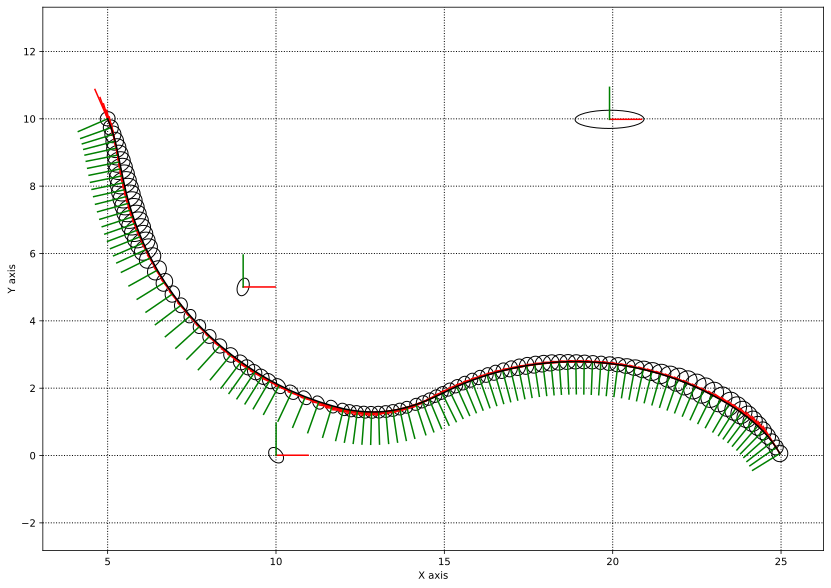

In [19]:
fig = plt.figure(0, figsize=(14,10), dpi=100)
for i in range(n_X_nodes):
    gtsam_plot.plot_pose2(0, result.atPose2(i+1), 0.95, marginals.marginalCovariance(i+1))
    
plt.plot( trace['x_y_psi'][ :,0 ], trace['x_y_psi'][ :,1 ], 'k' )

for landmark in pdf_landmarks.itertuples():
    xy = result.atPoint2(landmark.node_id)
    gtsam_plot.plot_pose2(0, gtsam.Pose2( xy[0], xy[1], 0.0 ), 0.95, marginals.marginalCovariance(landmark.node_id) )
    
plt.axis('equal')
plt.grid(color='k', linestyle=':', linewidth=1)
plt.show()